In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample

In [2]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow is using GPU:", tf.test.is_gpu_available())


Num GPUs Available: 1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
TensorFlow is using GPU: True


In [28]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Adjust memory as needed
        print("GPU is enabled and configured.")
    except RuntimeError as e:
        print(e)


ValueError: Cannot set memory growth on device when virtual devices configured

In [129]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow is using GPU:", tf.test.is_built_with_cuda())
print("Physical Devices:", tf.config.list_physical_devices('GPU'))


Num GPUs Available: 1
TensorFlow is using GPU: True
Physical Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [47]:
# Define filtering functions
def lowpass_filter(data, cutoff=15, fs=2175, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data)

def bandpass_filter(data, lowcut=0.5, highcut=8, fs=30, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [48]:
# Cell 2: Define data augmentation function
def apply_gaussian_noise(signal, noise_std=0.02):
    noise = np.random.normal(0, noise_std, signal.shape)
    return signal + noise

In [49]:
def process_ppg_file(signal_path, label_path, target_sampling_rate=30, augment=False):
    signal_data = pd.read_csv(signal_path, header=None).values.flatten()
    label_data = pd.read_csv(label_path)
    
    filtered_signal = lowpass_filter(signal_data)
    original_sampling_rate = 2175
    num_samples = int(len(filtered_signal) * (target_sampling_rate / original_sampling_rate))
    downsampled_signal = resample(filtered_signal, num_samples)
    processed_signal = bandpass_filter(downsampled_signal, fs=target_sampling_rate)
    processed_signal = (processed_signal - np.mean(processed_signal)) / np.std(processed_signal)
    
    glucose_level = label_data['Glucose'].values[0]
    age = label_data['Age'].values[0]
    gender = 1 if label_data['Gender'].values[0] == 'Male' else 0
    
    augmented_signals = [processed_signal]
    
    if augment:
        for _ in range(3):  # Apply Gaussian noise 3 times per signal
            augmented_signals.append(apply_gaussian_noise(processed_signal))
    
    return [(sig, glucose_level, age, gender) for sig in augmented_signals]


In [50]:
def process_all_ppg_files(root_folder, output_file, augment=False):
    signal_folder = os.path.join(root_folder, "RawData")
    label_folder = os.path.join(root_folder, "Labels")
    
    if not os.path.exists(signal_folder):
        raise FileNotFoundError(f"Error: Signal folder not found at {signal_folder}")
    if not os.path.exists(label_folder):
        raise FileNotFoundError(f"Error: Label folder not found at {label_folder}")
    
    processed_data = []
    
    for signal_file in os.listdir(signal_folder):
        if signal_file.startswith('signal') and signal_file.endswith('.csv'):
            label_file = signal_file.replace('signal', 'label')
            signal_path = os.path.join(signal_folder, signal_file)
            label_path = os.path.join(label_folder, label_file)
            
            if os.path.exists(label_path):
                processed_data.extend(process_ppg_file(signal_path, label_path, augment=augment))
            else:
                print(f"Warning: No matching label file for {signal_file}")
    
    df = pd.DataFrame(processed_data, columns=['PPG_Signal', 'Glucose_Level', 'Age', 'Gender'])
    df.to_pickle(output_file)
    print(f"Processed data saved to {output_file}. Dataset size: {len(df)} samples.")

In [51]:
def plot_ppg_signals(pickle_file, num_samples=5):
    df = pd.read_pickle(pickle_file)
    plt.figure(figsize=(12, 6))
    for i in range(min(num_samples, len(df))):
        ppg_signal = df.iloc[i]["PPG_Signal"]
        plt.plot(ppg_signal, label=f"Sample {i+1} (Glucose: {df.iloc[i]['Glucose_Level']} mg/dL)")
    plt.xlabel("Time (samples at 30Hz)")
    plt.ylabel("Normalized PPG Amplitude")
    plt.title("Visualization of Processed PPG Signals")
    plt.legend()
    plt.show()


Processed data saved to processed_ppg_data.pkl. Dataset size: 268 samples.


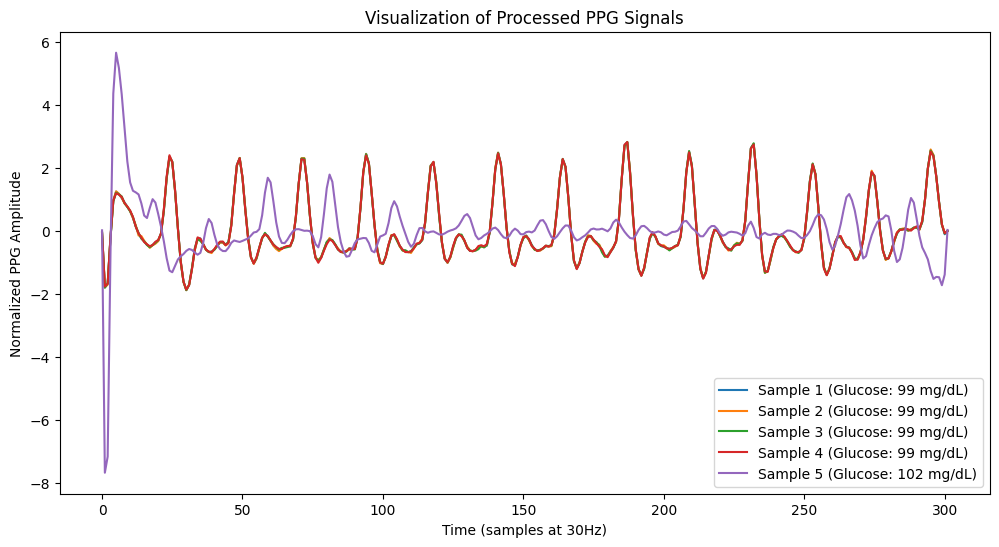

In [52]:
process_all_ppg_files("C:/Users/Tiddie Destroyer/Downloads/PPG_Dataset/PPG_Dataset", "processed_ppg_data.pkl", augment=True)
plot_ppg_signals("processed_ppg_data.pkl")


In [64]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.signal import butter, filtfilt, resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# def split_train_test(pickle_file, test_size=0.2, random_state=42):
#     df = pd.read_pickle(pickle_file)
#     df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)  # Shuffle dataset
    
#     X = np.array(df['PPG_Signal'].tolist())  # Convert list of arrays into a NumPy array
#     y = df['Glucose_Level'].values  # Target variable
    
#     scaler_X = MinMaxScaler()
#     X = scaler_X.fit_transform(X)
    
#     # ADD THIS CODE HERE to save the X scaler
#     with open('glucose_ensemble/scaler_X.pkl', 'wb') as f:
#         pickle.dump(scaler_X, f)
    
#     scaler_y = MinMaxScaler()
#     y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
#     print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")
#     return X_train, X_test, y_train, y_test, scaler_y

def split_train_test(pickle_file, test_size=0.2, random_state=42):
    df = pd.read_pickle(pickle_file)
    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    X = np.array(df['PPG_Signal'].tolist())
    y = df['Glucose_Level'].values
    
    scaler_X = MinMaxScaler()
    X = scaler_X.fit_transform(X)
    
    with open('glucose_ensemble/scaler_X.pkl', 'wb') as f:
        pickle.dump(scaler_X, f)
    
    scaler_y = MinMaxScaler()
    y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")
    return X_train, X_test, y_train, y_test, scaler_y

In [54]:
# Cell 8: Train a Random Forest Model
def train_model(X_train, y_train, n_estimators=150, random_state=42):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    model.fit(X_train, y_train)
    return model

In [55]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R^2 Score: {r2:.2f}")
    

In [56]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler

In [57]:
X_train, X_test, y_train, y_test, scaler_y = split_train_test("processed_ppg_data.pkl")
model = train_model(X_train, y_train)
evaluate_model(model, X_test, y_test)

Train set size: 214, Test set size: 54
Mean Absolute Error: 0.03
Root Mean Squared Error: 0.05
R^2 Score: 0.96


In [58]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def build_cnn_gru_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        Conv1D(128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        GRU(128, return_sequences=True, activation='relu'),
        GRU(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def train_cnn_gru_model(X_train, y_train, X_test, y_test, epochs=100, batch_size=32):
    input_shape = (X_train.shape[1], 1)
    X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)
    model = build_cnn_gru_model(input_shape)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    return model

model = train_cnn_gru_model(X_train, y_train, X_test, y_test)
model.save("glucose_cnn_gru_model.h5")

Epoch 1/100
7/7 [==============================] - 5s 315ms/step - loss: 0.1202 - mae: 0.2603 - val_loss: 0.1451 - val_mae: 0.2940
Epoch 2/100
7/7 [==============================] - 2s 265ms/step - loss: 0.0377 - mae: 0.1423 - val_loss: 0.1397 - val_mae: 0.2852
Epoch 3/100
7/7 [==============================] - 2s 276ms/step - loss: 0.0286 - mae: 0.1280 - val_loss: 0.1351 - val_mae: 0.2775
Epoch 4/100
7/7 [==============================] - 2s 275ms/step - loss: 0.0263 - mae: 0.1196 - val_loss: 0.1341 - val_mae: 0.2757
Epoch 5/100
7/7 [==============================] - 2s 282ms/step - loss: 0.0232 - mae: 0.1107 - val_loss: 0.1298 - val_mae: 0.2682
Epoch 6/100
7/7 [==============================] - 2s 269ms/step - loss: 0.0211 - mae: 0.1025 - val_loss: 0.1255 - val_mae: 0.2602
Epoch 7/100
7/7 [==============================] - 2s 257ms/step - loss: 0.0187 - mae: 0.1021 - val_loss: 0.1190 - val_mae: 0.2486
Epoch 8/100
7/7 [==============================] - 2s 282ms/step - loss: 0.0163 - m

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_cnn_gru_model(model, X_test, y_test, scaler_y):
    X_test = np.expand_dims(X_test, axis=-1)
    y_pred = model.predict(X_test)
    
    # Convert back to original glucose scale
    y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model Evaluation:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")

    return mae, rmse, r2

# Evaluate the trained model
evaluate_cnn_gru_model(model, X_test, y_test, scaler_y)


2/2 [==============================] - 0s 36ms/step
Model Evaluation:
MAE: 6.02
RMSE: 9.14
R² Score: 0.84


(6.023526509602866, 9.135611068583842, 0.8444748761747771)

In [155]:
def build_optimized_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True, activation='relu'), input_shape=input_shape),
        Bidirectional(LSTM(128, return_sequences=True)),
        Bidirectional(LSTM(64)),
        BatchNormalization(),
        Dropout(0.1),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.0002), loss='mse', metrics=['mae'])
    return model

In [164]:
def train_optimized_lstm(X_train, y_train, X_test, y_test, model_path='optimized_lstm_model3.h5', epochs=150, batch_size=32):
    input_shape = (X_train.shape[1], 1)
    X_train = np.expand_dims(X_train, axis=-1)  # Reshape for LSTM
    X_test = np.expand_dims(X_test, axis=-1)
    
    model = build_optimized_lstm_model(input_shape)
    
    early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
    
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])
    model.save(model_path)
    print(f"Optimized model saved to {model_path}")
    return model

In [165]:
def evaluate_model(model, X_test, y_test, scaler_y):
    X_test = np.expand_dims(X_test, axis=-1)  # Ensure correct shape for predictions
    y_pred = model.predict(X_test)
    
    # Inverse transform predictions to original glucose scale
    y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    # Compute Metrics
    mae = mean_absolute_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    # Plot actual vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_original, y_pred_original, alpha=0.7, label='Predicted vs Actual')
    plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], 'r', linestyle='--')
    plt.xlabel("Actual Glucose Level")
    plt.ylabel("Predicted Glucose Level")
    plt.title("Predicted vs. Actual Glucose Levels")
    plt.legend()
    plt.show()
    
    return mae, rmse, r2

In [ ]:
X_train, X_test, y_train, y_test, scaler_y = split_train_test("processed_ppg_data.pkl")
lstm_model = train_optimized_lstm(X_train, y_train, X_test, y_test)


Train set size: 214, Test set size: 54
Epoch 1/150
7/7 [==============================] - 11s 930ms/step - loss: 0.0725 - mae: 0.2071 - val_loss: 0.1315 - val_mae: 0.2711 - lr: 2.0000e-04
Epoch 2/150
7/7 [==============================] - 5s 798ms/step - loss: 0.0517 - mae: 0.1772 - val_loss: 0.1212 - val_mae: 0.2531 - lr: 2.0000e-04
Epoch 3/150
7/7 [==============================] - 5s 782ms/step - loss: 0.0462 - mae: 0.1609 - val_loss: 0.1199 - val_mae: 0.2510 - lr: 2.0000e-04
Epoch 4/150
7/7 [==============================] - 5s 772ms/step - loss: 0.0397 - mae: 0.1458 - val_loss: 0.1148 - val_mae: 0.2426 - lr: 2.0000e-04
Epoch 5/150
7/7 [==============================] - 7s 911ms/step - loss: 0.0361 - mae: 0.1403 - val_loss: 0.1080 - val_mae: 0.2318 - lr: 2.0000e-04
Epoch 6/150
7/7 [==============================] - 6s 942ms/step - loss: 0.0327 - mae: 0.1364 - val_loss: 0.1085 - val_mae: 0.2324 - lr: 2.0000e-04
Epoch 7/150
7/7 [==============================] - 8s 1s/step - loss: 0.

2/2 [==============================] - 2s 128ms/step
Mean Absolute Error: 1.85
Root Mean Squared Error: 2.33
R² Score: 0.99


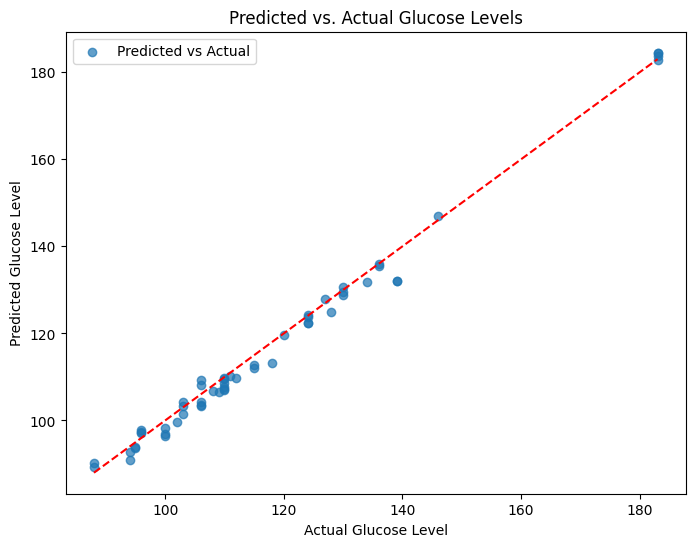

(1.8471086290147571, 2.3334737866430637, 0.9898531508282381)

In [167]:
evaluate_model(lstm_model, X_test, y_test, scaler_y)

In [180]:
def build_ensemble_lstm_model(input_shape):
    models = []
    for _ in range(3):  # Create 3 separate LSTM models
        model = Sequential([
            Bidirectional(LSTM(256, return_sequences=True, activation='relu'), input_shape=input_shape),
            Bidirectional(LSTM(128, return_sequences=True)),
            Bidirectional(LSTM(64)),
            BatchNormalization(),
            Dropout(0.1),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(1)  # Output layer for regression
        ])
        model.compile(optimizer=Adam(learning_rate=0.0002), loss='mse', metrics=['mae'])
        models.append(model)
    return models


In [181]:
def train_ensemble_lstm(X_train, y_train, X_test, y_test, model_paths=['lstm_model_1.h5', 'lstm_model_2.h5', 'lstm_model_3.h5'], epochs=150, batch_size=32):
    input_shape = (X_train.shape[1], 1)
    X_train = np.expand_dims(X_train, axis=-1)  # Reshape for LSTM
    X_test = np.expand_dims(X_test, axis=-1)
    
    models = build_ensemble_lstm_model(input_shape)
    
    early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
    
    for i, model in enumerate(models):
        print(f"Training model {i+1}...")
        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])
        model.save(model_paths[i])
        print(f"Model {i+1} saved to {model_paths[i]}")
    
    return models

In [182]:
def ensemble_predict(models, X_test):
    X_test = np.expand_dims(X_test, axis=-1)
    predictions = np.array([model.predict(X_test) for model in models])
    final_predictions = np.mean(predictions, axis=0)  # Average predictions from all models
    return final_predictions.flatten()

In [183]:
X_train, X_test, y_train, y_test, scaler_y = split_train_test("processed_ppg_data.pkl")
ensemble_models = train_ensemble_lstm(X_train, y_train, X_test, y_test)
y_pred = ensemble_predict(ensemble_models, X_test)

Train set size: 214, Test set size: 54
Training model 1...
Epoch 1/150
7/7 [==============================] - 12s 1s/step - loss: 0.0792 - mae: 0.2193 - val_loss: 0.1382 - val_mae: 0.2828 - lr: 2.0000e-04
Epoch 2/150
7/7 [==============================] - 6s 840ms/step - loss: 0.0527 - mae: 0.1783 - val_loss: 0.1215 - val_mae: 0.2537 - lr: 2.0000e-04
Epoch 3/150
7/7 [==============================] - 5s 795ms/step - loss: 0.0426 - mae: 0.1595 - val_loss: 0.1142 - val_mae: 0.2412 - lr: 2.0000e-04
Epoch 4/150
7/7 [==============================] - 5s 792ms/step - loss: 0.0401 - mae: 0.1547 - val_loss: 0.1135 - val_mae: 0.2408 - lr: 2.0000e-04
Epoch 5/150
7/7 [==============================] - 6s 872ms/step - loss: 0.0348 - mae: 0.1374 - val_loss: 0.1110 - val_mae: 0.2371 - lr: 2.0000e-04
Epoch 6/150
7/7 [==============================] - 5s 739ms/step - loss: 0.0328 - mae: 0.1377 - val_loss: 0.1036 - val_mae: 0.2259 - lr: 2.0000e-04
Epoch 7/150
7/7 [==============================] - 6s 8

In [184]:
y_pred = ensemble_predict(ensemble_models, X_test)

2/2 [==============================] - 0s 135ms/step


In [185]:
def evaluate_ensemble(models, X_test, y_test, scaler_y):
    y_pred = ensemble_predict(models, X_test)
    y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Ideal line
    plt.xlabel("Actual Glucose Level")
    plt.ylabel("Predicted Glucose Level")
    plt.title("Predicted vs. Actual Glucose Levels")
    plt.legend()
    plt.show()
    
    return mae, rmse, r2


2/2 [==============================] - 0s 132ms/step
Mean Absolute Error: 3.56
Root Mean Squared Error: 4.96
R² Score: 0.95


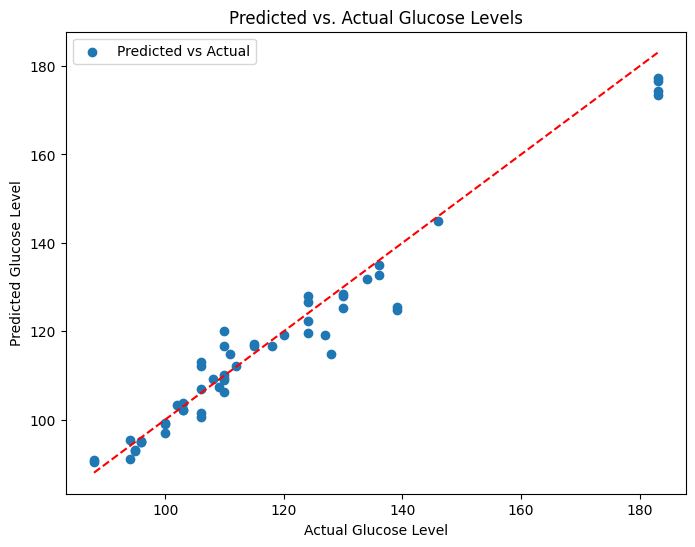

(3.5567799320927374, 4.955195533271473, 0.9542441165801818)

In [186]:
evaluate_ensemble(ensemble_models, X_test, y_test, scaler_y)

In [228]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

def save_ensemble_model(models, scaler_y, base_path='model_ensemble'):
    """
    Save an ensemble of models along with the scaler used for the target variable.
    
    Parameters:
    -----------
    models : list
        List of Keras models in the ensemble
    scaler_y : object
        The scaler used to transform the target variable
    base_path : str
        Base directory to save all model files
    """
    # Create the directory if it doesn't exist
    os.makedirs(base_path, exist_ok=True)
    
    # Save each model
    model_paths = []
    for i, model in enumerate(models):
        model_path = os.path.join(base_path, f'model_{i+1}.h5')
        model.save(model_path)
        model_paths.append(model_path)
    
    # Save the scaler
    scaler_path = os.path.join(base_path, 'scaler_y.pkl')
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler_y, f)
    
    # Save metadata about the ensemble
    metadata = {
        'num_models': len(models),
        'model_paths': model_paths,
        'scaler_path': scaler_path
    }
    
    metadata_path = os.path.join(base_path, 'metadata.pkl')
    with open(metadata_path, 'wb') as f:
        pickle.dump(metadata, f)
    
    print(f"Ensemble model saved to {base_path}")
    return metadata_path

def load_ensemble_model(metadata_path):
    """
    Load an ensemble of models along with the scaler used for the target variable.
    
    Parameters:
    -----------
    metadata_path : str
        Path to the metadata file
    
    Returns:
    --------
    models : list
        List of loaded Keras models
    scaler_y : object
        The scaler used to transform the target variable
    """
    # Load metadata
    with open(metadata_path, 'rb') as f:
        metadata = pickle.load(f)
    
    # Load models
    models = []
    for model_path in metadata['model_paths']:
        model = load_model(model_path)
        models.append(model)
    
    # Load scaler
    with open(metadata['scaler_path'], 'rb') as f:
        scaler_y = pickle.load(f)
    
    print(f"Loaded ensemble with {len(models)} models")
    return models, scaler_y


In [229]:
def predict_glucose_levels(ppg_data, models, scaler_y):
    """
    Make predictions using the loaded ensemble model.
    
    Parameters:
    -----------
    ppg_data : numpy.ndarray
        Preprocessed PPG signal data
    models : list
        List of loaded Keras models
    scaler_y : object
        The scaler used to transform the target variable
    
    Returns:
    --------
    predictions : numpy.ndarray
        Predicted glucose levels
    """
    # Ensure data is properly shaped for LSTM
    if len(ppg_data.shape) == 2:
        ppg_data = np.expand_dims(ppg_data, axis=-1)
    
    # Make predictions with each model in the ensemble
    predictions = np.array([model.predict(ppg_data) for model in models])
    
    # Average predictions from all models
    final_predictions = np.mean(predictions, axis=0)
    
    # Inverse transform to get actual glucose levels
    glucose_levels = scaler_y.inverse_transform(final_predictions)
    
    return glucose_levels.flatten()

In [230]:
# After your training is complete
X_train, X_test, y_train, y_test, scaler_y = split_train_test("processed_ppg_data.pkl")
ensemble_models = train_ensemble_lstm(X_train, y_train, X_test, y_test)

# Save the complete ensemble
metadata_path = save_ensemble_model(ensemble_models, scaler_y, base_path='glucose_ensemble')

Train set size: 214, Test set size: 54
Training model 1...
Epoch 1/150
7/7 [==============================] - 13s 1s/step - loss: 0.0709 - mae: 0.2086 - val_loss: 0.1307 - val_mae: 0.2702 - lr: 2.0000e-04
Epoch 2/150
7/7 [==============================] - 6s 849ms/step - loss: 0.0519 - mae: 0.1766 - val_loss: 0.1190 - val_mae: 0.2492 - lr: 2.0000e-04
Epoch 3/150
7/7 [==============================] - 6s 839ms/step - loss: 0.0456 - mae: 0.1577 - val_loss: 0.1172 - val_mae: 0.2464 - lr: 2.0000e-04
Epoch 4/150
7/7 [==============================] - 6s 826ms/step - loss: 0.0379 - mae: 0.1481 - val_loss: 0.1139 - val_mae: 0.2416 - lr: 2.0000e-04
Epoch 5/150
7/7 [==============================] - 6s 891ms/step - loss: 0.0349 - mae: 0.1428 - val_loss: 0.1133 - val_mae: 0.2411 - lr: 2.0000e-04
Epoch 6/150
7/7 [==============================] - 6s 859ms/step - loss: 0.0314 - mae: 0.1329 - val_loss: 0.1137 - val_mae: 0.2417 - lr: 2.0000e-04
Epoch 7/150
7/7 [==============================] - 6s 8

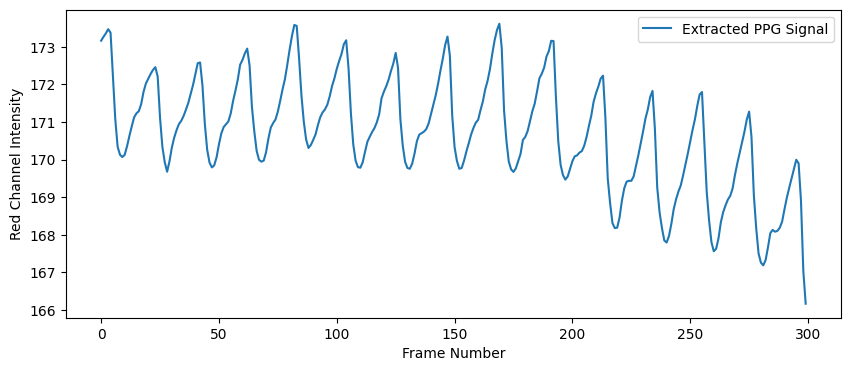

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the recorded video
cap = cv2.VideoCapture("PPG_Unseen/PPGDinner.mp4")
red_channel_values = []

frame_rate = cap.get(cv2.CAP_PROP_FPS)  # Get actual FPS
start_frame = int(0 * frame_rate)  # Start at 10s
end_frame = int(10 * frame_rate)  # End at 20s

cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)  # Jump to 10s frame

while cap.isOpened():
    frame_idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    if frame_idx >= end_frame:
        break
    ret, frame = cap.read()
    if not ret:
        break
    # Extract the red channel (assuming OpenCV loads as BGR)
    red_channel = frame[:, :, 2]
    avg_intensity = np.mean(red_channel)
    red_channel_values.append(avg_intensity)

cap.release()

# Convert to NumPy array
ppg_signal = np.array(red_channel_values)

# Plot the extracted PPG signal
plt.figure(figsize=(10, 4))
plt.plot(ppg_signal, label="Extracted PPG Signal")
plt.xlabel("Frame Number")
plt.ylabel("Red Channel Intensity")
plt.legend()
plt.show()


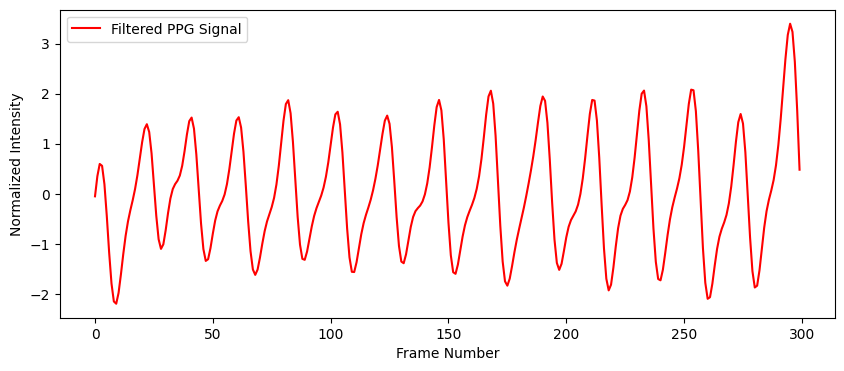

In [173]:
from scipy.signal import butter, filtfilt

# Apply bandpass filter (0.5 - 4 Hz to match heart rate range)
def bandpass_filter(signal, lowcut=0.5, highcut=4.0, fs=30, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Assume a 30 Hz sampling rate (approximate for phone cameras)
filtered_ppg = bandpass_filter(ppg_signal, fs=30)

# Plot filtered signal
plt.figure(figsize=(10, 4))
plt.plot(filtered_ppg, label="Filtered PPG Signal", color='red')
plt.xlabel("Frame Number")
plt.ylabel("Normalized Intensity")
plt.legend()
plt.show()


In [86]:
# def moving_average(signal, window_size=5):
#     return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

# # Apply moving average
# smoothed_ppg = moving_average(ppg_bandpassed, window_size=5)

# # Plot smoothed signal
# plt.figure(figsize=(10, 4))
# plt.plot(smoothed_ppg, label="Smoothed PPG Signal", color="blue")
# plt.xlabel("Frame Number")
# plt.ylabel("Normalized Intensity")
# plt.legend()
# plt.show()


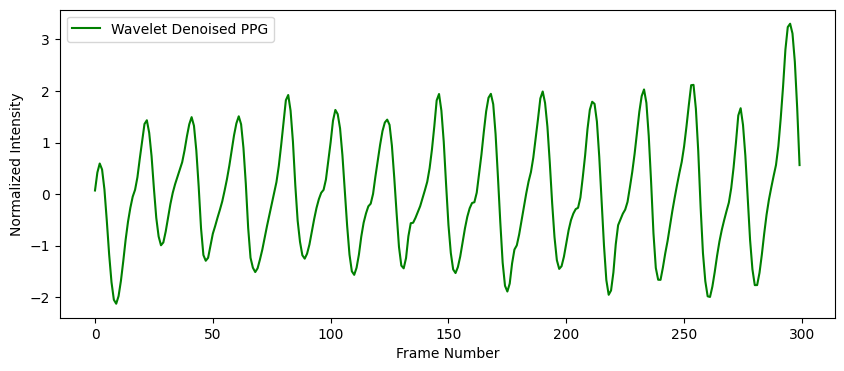

In [174]:
import pywt
import numpy as np

def wavelet_denoise(signal, wavelet='db4', level=2):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeffs[1:] = [pywt.threshold(c, np.std(c)/3, mode='soft') for c in coeffs[1:]]  
    return pywt.waverec(coeffs, wavelet)

# Apply wavelet denoising to your PPG signal
ppg_denoised = wavelet_denoise(filtered_ppg, wavelet='db4', level=2)

# Plot denoised signal
plt.figure(figsize=(10, 4))
plt.plot(ppg_denoised, label="Wavelet Denoised PPG", color="green")
plt.xlabel("Frame Number")
plt.ylabel("Normalized Intensity")
plt.legend()
plt.show()


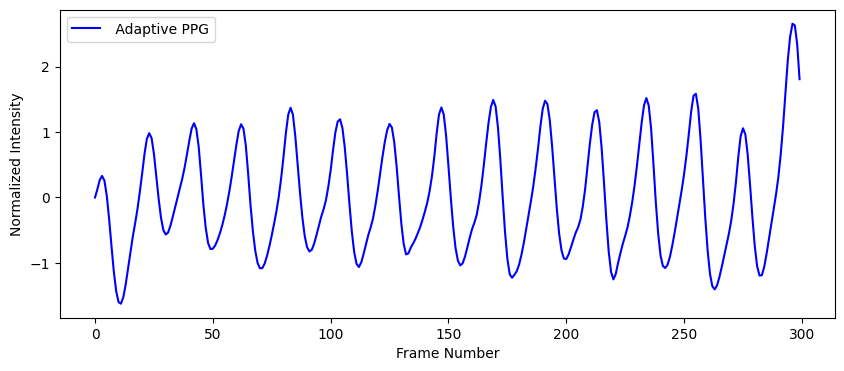

In [175]:
from scipy.signal import lfilter

def adaptive_filter(signal, alpha=0.7):  # Reduce alpha
    filtered_signal = np.zeros_like(signal)
    for i in range(1, len(signal)):
        filtered_signal[i] = alpha * filtered_signal[i-1] + (1-alpha) * signal[i]
    return filtered_signal


# Apply adaptive filtering
ppg_filtered = adaptive_filter(ppg_denoised)

# Plot denoised signal
plt.figure(figsize=(10, 4))
plt.plot(ppg_filtered, label=" Adaptive PPG", color="blue")
plt.xlabel("Frame Number")
plt.ylabel("Normalized Intensity")
plt.legend()
plt.show()


In [176]:
# Add this before applying the scaler
def normalize_signal(signal):
    return (signal - np.mean(signal)) / np.std(signal)

# Then apply it before the scaler
normalized_signal = normalize_signal(ppg_filtered)
filtered_ppg_normalized = scaler_y.transform(normalized_signal.reshape(-1, 1)).flatten()

In [177]:
# Ensure the processed PPG signal is within the same range as training data
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import pickle

# Load the same scaler used during training
with open("glucose_ensemble/scaler_y.pkl", "rb") as f:
    scaler_X = pickle.load(f)

filtered_ppg_normalized = scaler_X.transform(ppg_filtered.reshape(-1, 1)).flatten()


In [178]:
# Ensure correct input shape
X_unseen = np.expand_dims(normalized_signal, axis=-1)  # Should be (625, 1)

# Check input shape
print(f"Shape before trimming: {X_unseen.shape}")

# Trim or pad the sequence if needed
expected_length = 302  # Change this if your model expects a different length
if X_unseen.shape[0] > expected_length:
    X_unseen = X_unseen[:expected_length]  # Trim to match expected shape
elif X_unseen.shape[0] < expected_length:
    X_unseen = np.pad(X_unseen, ((0, expected_length - X_unseen.shape[0]), (0, 0)), mode='constant')

# Reshape for LSTM input
X_unseen = np.expand_dims(X_unseen, axis=0)  # Add batch dimension

print(f"Shape after reshaping: {X_unseen.shape}")  # Should be (1, 302, 1)


Shape before trimming: (300, 1)
Shape after reshaping: (1, 302, 1)


In [100]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

In [93]:
def load_ensemble_model(metadata_path):
    """
    Load an ensemble of models along with the scaler used for the target variable.
    
    Parameters:
    -----------
    metadata_path : str
        Path to the metadata file
    
    Returns:
    --------
    models : list
        List of loaded Keras models
    scaler_y : object
        The scaler used to transform the target variable
    """
    # Load metadata
    with open(metadata_path, 'rb') as f:
        metadata = pickle.load(f)
    
    # Load models
    models = []
    for model_path in metadata['model_paths']:
        model = load_model(model_path)
        models.append(model)
    
    # Load scaler
    with open(metadata['scaler_path'], 'rb') as f:
        scaler_y = pickle.load(f)
    
    print(f"Loaded ensemble with {len(models)} models")
    return models, scaler_y

In [94]:
# import numpy as np
# import scipy.signal as signal
# import matplotlib.pyplot as plt

# # Function to compute Signal-to-Noise Ratio (SNR)
# def compute_snr(ppg_signal):
#     signal_power = np.mean(ppg_signal ** 2)
#     noise_power = np.mean((ppg_signal - np.mean(ppg_signal)) ** 2)
#     snr = 10 * np.log10(signal_power / noise_power)
#     return snr

# # Function to detect peaks (Heart Rate Check)
# def detect_peaks(ppg_signal, fs=30):
#     peaks, _ = signal.find_peaks(ppg_signal, distance=fs/2)  # Assuming heart rate ~60-100 bpm
#     return len(peaks) / (len(ppg_signal) / fs) * 60  # Convert to BPM

# # Function to compute Power Spectral Density (PSD)
# def compute_psd(ppg_signal, fs=30):
#     freqs, psd = signal.welch(ppg_signal, fs=fs, nperseg=fs*4)
#     return freqs, psd

# # Function to compute Coefficient of Variation (CV)
# def compute_cv(ppg_signal):
#     return np.std(ppg_signal) / np.mean(ppg_signal)

# # Load your PPG signal (replace with actual data)
# ppg_signal = ppg_filtered  # Use your preprocessed PPG signal
# fs = 30  # Sampling rate (30 Hz)

# # Compute signal stability metrics
# snr = compute_snr(ppg_signal)
# heart_rate = detect_peaks(ppg_signal, fs)
# cv = compute_cv(ppg_signal)
# freqs, psd = compute_psd(ppg_signal, fs)

# # Display results
# print(f"Signal-to-Noise Ratio (SNR): {snr:.2f} dB")
# print(f"Estimated Heart Rate: {heart_rate:.1f} BPM")
# print(f"Coefficient of Variation (CV): {cv:.3f}")

# # Plot PPG waveform
# plt.figure(figsize=(10, 4))
# plt.plot(ppg_signal, label="PPG Signal", color='blue')
# plt.xlabel("Time (samples)")
# plt.ylabel("Amplitude")
# plt.title("PPG Signal Stability Analysis")
# plt.legend()
# plt.show()

# # Plot Power Spectral Density
# plt.figure(figsize=(8, 4))
# plt.semilogy(freqs, psd, color='red')
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Power Spectral Density")
# plt.title("PPG Signal Frequency Analysis")
# plt.show()


In [101]:
def ensemble_predict(models, X_test):
    X_test = np.expand_dims(X_test, axis=-1)  # Ensure correct shape for LSTM
    predictions = np.array([model.predict(X_test) for model in models])  # Get predictions from all models
    final_predictions = np.mean(predictions, axis=0)  # Average predictions
    return final_predictions.flatten()

# Load the ensemble model and scaler
metadata_path = 'glucose_ensemble/metadata.pkl'
loaded_models, loaded_scaler_y = load_ensemble_model(metadata_path)

# Predict glucose level
y_pred = ensemble_predict(loaded_models, X_unseen)

# Convert predictions back to original glucose scale
y_pred_original = loaded_scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"Predicted Blood Glucose Level: {y_pred_original[0]:.2f} mg/dL")


Loaded ensemble with 3 models
1/1 [==============================] - 1s 1s/step
Predicted Blood Glucose Level: 91.73 mg/dL


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle
import os
from scipy.signal import butter, filtfilt, resample
import pandas as pd
import cv2  # Added for video extraction

# Define the extract_ppg_from_video function here instead of importing it
def extract_ppg_from_video(video_path, start_time=0, duration=30, roi_percent=0.5):
    """
    Extract PPG signal from video with improved region of interest selection
    
    Parameters:
    -----------
    video_path : str
        Path to the video file
    start_time : int
        Start time in seconds
    duration : int
        Duration to extract in seconds
    roi_percent : float
        Percentage of the center of the frame to use (0-1)
    
    Returns:
    --------
    ppg_signal : numpy.ndarray
        Extracted PPG signal
    sampling_rate : float
        Sampling rate of the extracted signal
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")
    
    # Get video properties
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video loaded: {video_path}")
    print(f"Frame rate: {frame_rate:.2f} fps")
    print(f"Resolution: {frame_width}x{frame_height}")
    print(f"Total frames: {total_frames}")
    
    # Calculate frame numbers
    start_frame = int(start_time * frame_rate)
    end_frame = min(int((start_time + duration) * frame_rate), total_frames)
    
    # Calculate ROI coordinates (center of the frame)
    roi_size = int(min(frame_width, frame_height) * roi_percent)
    x_start = (frame_width - roi_size) // 2
    y_start = (frame_height - roi_size) // 2
    
    # Skip to start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Extract red channel values
    red_channel_values = []
    frame_count = 0
    
    while cap.isOpened():
        frame_idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        if frame_idx >= end_frame:
            break
            
        ret, frame = cap.read()
        if not ret:
            break
            
        # Extract the red channel (assuming OpenCV loads as BGR)
        red_channel = frame[:, :, 2]
        avg_intensity = np.mean(red_channel)
        red_channel_values.append(avg_intensity)
        frame_count += 1
    
    cap.release()
    ppg_signal = np.array(red_channel_values)
    
    print(f"Extracted {len(ppg_signal)} frames of PPG data")
    return ppg_signal, frame_rate

def test_scaler(scaler_path):
    """
    Test the scaler to ensure it works correctly.
    
    Parameters:
    -----------
    scaler_path : str
        Path to the scaler file
        
    Returns:
    --------
    is_working : bool
        Whether the scaler is working correctly
    """
    try:
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        
        # Test inverse_transform with sample data
        sample_data = np.array([[0.5]])
        original_value = scaler.inverse_transform(sample_data)[0][0]
        
        print(f"Scaler test:")
        print(f"- Input value: 0.5 (normalized)")
        print(f"- Output value: {original_value:.2f} (original scale)")
        
        # Test transform with sample data
        sample_glucose = np.array([[100.0]])
        normalized_value = scaler.transform(sample_glucose)[0][0]
        
        print(f"- Input value: 100.0 (original scale)")
        print(f"- Output value: {normalized_value:.4f} (normalized)")
        
        # Test extremes
        print("\nTesting scaler with extreme values:")
        for value in [0.0, 0.25, 0.5, 0.75, 1.0]:
            original = scaler.inverse_transform([[value]])[0][0]
            print(f"- Normalized {value:.2f} → Original {original:.2f} mg/dL")
        
        return True
    except Exception as e:
        print(f"Error testing scaler: {str(e)}")
        return False

def load_training_data_stats(data_pickle):
    """
    Load statistics from the training data.
    
    Parameters:
    -----------
    data_pickle : str
        Path to the training data pickle file
        
    Returns:
    --------
    stats : dict
        Dictionary with training data statistics
    """
    try:
        # Load data
        df = pd.read_pickle(data_pickle)
        
        # Extract PPG signals
        signals = df['PPG_Signal'].tolist()
        
        # Calculate statistics
        signal_lengths = [len(signal) for signal in signals]
        glucose_values = df['Glucose_Level'].values
        
        stats = {
            'sample_count': len(signals),
            'min_length': min(signal_lengths),
            'max_length': max(signal_lengths),
            'mean_length': np.mean(signal_lengths),
            'min_glucose': np.min(glucose_values),
            'max_glucose': np.max(glucose_values),
            'mean_glucose': np.mean(glucose_values),
            'std_glucose': np.std(glucose_values)
        }
        
        print("\nTraining data statistics:")
        print(f"- Number of samples: {stats['sample_count']}")
        print(f"- Signal lengths: min={stats['min_length']}, max={stats['max_length']}, mean={stats['mean_length']:.1f}")
        print(f"- Glucose values (mg/dL): min={stats['min_glucose']:.1f}, max={stats['max_glucose']:.1f}, mean={stats['mean_glucose']:.1f}, std={stats['std_glucose']:.1f}")
        
        # Extract a sample signal for comparison
        sample_signal = signals[0]
        stats['sample_signal'] = sample_signal
        
        return stats
    except Exception as e:
        print(f"Error loading training data statistics: {str(e)}")
        return None

def test_model(model_path, scaler_path):
    """
    Test the model with synthetic data.
    
    Parameters:
    -----------
    model_path : str
        Path to the model file
    scaler_path : str
        Path to the scaler file
    """
    try:
        # Load model
        model = load_model(model_path)
        
        # Load scaler
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        
        # Print model summary
        print("\nModel summary:")
        model.summary()
        
        # Create synthetic signal with sine wave (common in PPG)
        sequence_length = 302  # From your code
        t = np.linspace(0, 10, sequence_length)
        synthetic_signal = np.sin(2 * np.pi * 1.2 * t) + 0.5 * np.sin(2 * np.pi * 2.5 * t)
        
        # Normalize
        synthetic_signal = (synthetic_signal - np.mean(synthetic_signal)) / np.std(synthetic_signal)
        
        # Prepare for model
        X = synthetic_signal.reshape(1, sequence_length, 1)
        
        # Make prediction
        y_pred = model.predict(X)
        glucose = scaler.inverse_transform(y_pred)[0][0]
        
        print(f"\nSynthetic data test:")
        print(f"- Predicted glucose from synthetic sine wave: {glucose:.2f} mg/dL")
        
        # Test with zeroes
        zero_signal = np.zeros((1, sequence_length, 1))
        zero_pred = model.predict(zero_signal)
        zero_glucose = scaler.inverse_transform(zero_pred)[0][0]
        
        print(f"- Predicted glucose from all zeros: {zero_glucose:.2f} mg/dL")
        
        # Test with random noise
        np.random.seed(42)
        noise_signal = np.random.normal(0, 1, (1, sequence_length, 1))
        noise_pred = model.predict(noise_signal)
        noise_glucose = scaler.inverse_transform(noise_pred)[0][0]
        
        print(f"- Predicted glucose from random noise: {noise_glucose:.2f} mg/dL")
        
        # Plot synthetic signal
        plt.figure(figsize=(10, 4))
        plt.plot(synthetic_signal)
        plt.title(f'Synthetic PPG Signal (Predicted: {glucose:.1f} mg/dL)')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig('synthetic_signal_test.png')
        plt.close()
        
        return True
    except Exception as e:
        print(f"Error testing model: {str(e)}")
        return False

def compare_preprocessing(training_sample, video_sample, sample_rate):
    """
    Compare preprocessing methods.
    
    Parameters:
    -----------
    training_sample : numpy.ndarray
        Sample signal from training data
    video_sample : numpy.ndarray
        Sample signal from video
    sample_rate : float
        Sampling rate of the video signal
    """
    plt.figure(figsize=(15, 10))
    
    # Original signals
    plt.subplot(3, 2, 1)
    plt.plot(training_sample)
    plt.title('Training Sample (Original)')
    plt.grid(alpha=0.3)
    
    plt.subplot(3, 2, 2)
    plt.plot(video_sample)
    plt.title('Video Sample (Original)')
    plt.grid(alpha=0.3)
    
    # Method 1: Standard preprocessing from fixed code
    def preprocess_standard(signal, fs):
        # Normalize
        normalized = (signal - np.mean(signal)) / np.std(signal)
        
        # Bandpass filter
        nyquist = 0.5 * fs
        low = 0.5 / nyquist
        high = 8 / nyquist
        b, a = butter(4, [low, high], btype='band')
        filtered = filtfilt(b, a, normalized)
        
        return filtered
    
    # Process training sample (assume fs=30 for training)
    processed_training = preprocess_standard(training_sample, 30)
    processed_video = preprocess_standard(video_sample, sample_rate)
    
    # Resample video signal to match training length
    if len(processed_video) != len(processed_training):
        processed_video = resample(processed_video, len(processed_training))
    
    plt.subplot(3, 2, 3)
    plt.plot(processed_training)
    plt.title('Training Sample (Preprocessed)')
    plt.grid(alpha=0.3)
    
    plt.subplot(3, 2, 4)
    plt.plot(processed_video)
    plt.title('Video Sample (Preprocessed)')
    plt.grid(alpha=0.3)
    
    # Frequency domain comparison
    from scipy.fft import fft, fftfreq
    
    def plot_fft(signal, fs, ax, title):
        n = len(signal)
        yf = fft(signal)
        xf = fftfreq(n, 1/fs)[:n//2]
        ax.plot(xf, 2.0/n * np.abs(yf[:n//2]))
        ax.set_title(title)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Amplitude')
        ax.set_xlim([0, 10])  # Focus on 0-10 Hz range
        ax.grid(alpha=0.3)
    
    plt.subplot(3, 2, 5)
    plot_fft(processed_training, 30, plt.gca(), 'Training Sample (Frequency Domain)')
    
    plt.subplot(3, 2, 6)
    plot_fft(processed_video, 30, plt.gca(), 'Video Sample (Frequency Domain)')
    
    plt.tight_layout()
    plt.savefig('preprocessing_comparison.png')
    plt.close()
    
    print("\nPreprocessing comparison:")
    print(f"- Training sample: length={len(training_sample)}, mean={np.mean(training_sample):.4f}, std={np.std(training_sample):.4f}")
    print(f"- Video sample: length={len(video_sample)}, mean={np.mean(video_sample):.4f}, std={np.std(video_sample):.4f}")
    print(f"- Processed training: length={len(processed_training)}, mean={np.mean(processed_training):.4f}, std={np.std(processed_training):.4f}")
    print(f"- Processed video: length={len(processed_video)}, mean={np.mean(processed_video):.4f}, std={np.std(processed_video):.4f}")

def run_diagnostics(model_path, scaler_path, data_pickle, video_path=None):
    """
    Run comprehensive diagnostics.
    
    Parameters:
    -----------
    model_path : str
        Path to the model file
    scaler_path : str
        Path to the scaler file
    data_pickle : str
        Path to the training data pickle file
    video_path : str
        Path to the video file for testing (optional)
    """
    print("=== GLUCOSE PREDICTION DIAGNOSTIC TOOL ===\n")
    
    # Test 1: Check scaler
    print("\n=== TEST 1: SCALER VALIDATION ===")
    scaler_valid = test_scaler(scaler_path)
    
    # Test 2: Check model
    print("\n=== TEST 2: MODEL VALIDATION ===")
    model_valid = test_model(model_path, scaler_path)
    
    # Test 3: Check training data statistics
    print("\n=== TEST 3: TRAINING DATA STATISTICS ===")
    training_stats = load_training_data_stats(data_pickle)
    
    # Test 4: Compare with video data (if provided)
    if video_path and os.path.exists(video_path):
        print("\n=== TEST 4: VIDEO DATA COMPARISON ===")
        # We now use the locally defined extract_ppg_from_video function
        video_signal, sampling_rate = extract_ppg_from_video(video_path)
        
        # Get sample of video signal (first 302 samples or pad if needed)
        if len(video_signal) > 302:
            video_sample = video_signal[:302]
        else:
            video_sample = np.pad(video_signal, (0, max(0, 302 - len(video_signal))), 'constant')
        
        # Compare preprocessing
        compare_preprocessing(training_stats['sample_signal'], video_sample, sampling_rate)
    
    # Summary
    print("\n=== DIAGNOSTIC SUMMARY ===")
    if scaler_valid and model_valid and training_stats is not None:
        print("✅ Basic diagnostics passed. Check the visualizations for more insights.")
    else:
        print("❌ Some tests failed. See the details above.")
    
    print("\nRecommendations:")
    if training_stats and ('max_glucose' in training_stats) and training_stats['max_glucose'] < 300:
        print("- Your training data maximum glucose is lower than your prediction (330 mg/dL).")
        print("  This suggests the model might be extrapolating beyond its training range.")
    
    print("- Verify that the preprocessing pipeline for video matches the training pipeline EXACTLY.")
    print("- Check for potential signal quality issues in your video.")
    print("- Ensure the model input shape is correct (should be [batch_size, sequence_length, 1]).")
    print("- Consider recording new video data with more stable lighting and less movement.")
    
    print("\nVisualizations saved to current directory.")


run_diagnostics("optimized_lstm_model3.h5", "glucose_ensemble/scaler_y.pkl", "processed_ppg_data.pkl", "PPG_Unseen/PPGDinner.mp4")

=== GLUCOSE PREDICTION DIAGNOSTIC TOOL ===


=== TEST 1: SCALER VALIDATION ===
Scaler test:
- Input value: 0.5 (normalized)
- Output value: 135.50 (original scale)
- Input value: 100.0 (original scale)
- Output value: 0.1263 (normalized)

Testing scaler with extreme values:
- Normalized 0.00 → Original 88.00 mg/dL
- Normalized 0.25 → Original 111.75 mg/dL
- Normalized 0.50 → Original 135.50 mg/dL
- Normalized 0.75 → Original 159.25 mg/dL
- Normalized 1.00 → Original 183.00 mg/dL

=== TEST 2: MODEL VALIDATION ===

Model summary:
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_66 (Bidirecti  (None, 302, 512)         528384    
 onal)                                                           
                                                                 
 bidirectional_67 (Bidirecti  (None, 302, 256)         656384    
 onal)                                         

1. Extracting PPG signal from video...
Video loaded: PPG_Unseen/PPGDinner.mp4
Frame rate: 30.00 fps
Resolution: 1080x1920
Total frames: 308
Using RED channel (variance: 2.51)
Extracted 308 frames of PPG data
2. Processing signal (sampling rate: 30.00 Hz)...
3. Predicting glucose level...
1/1 [==============================] - 1s 1s/step
4. Result: Predicted glucose level: 275.3 mg/dL
   Range: ABNORMAL
5. Generating visualization...


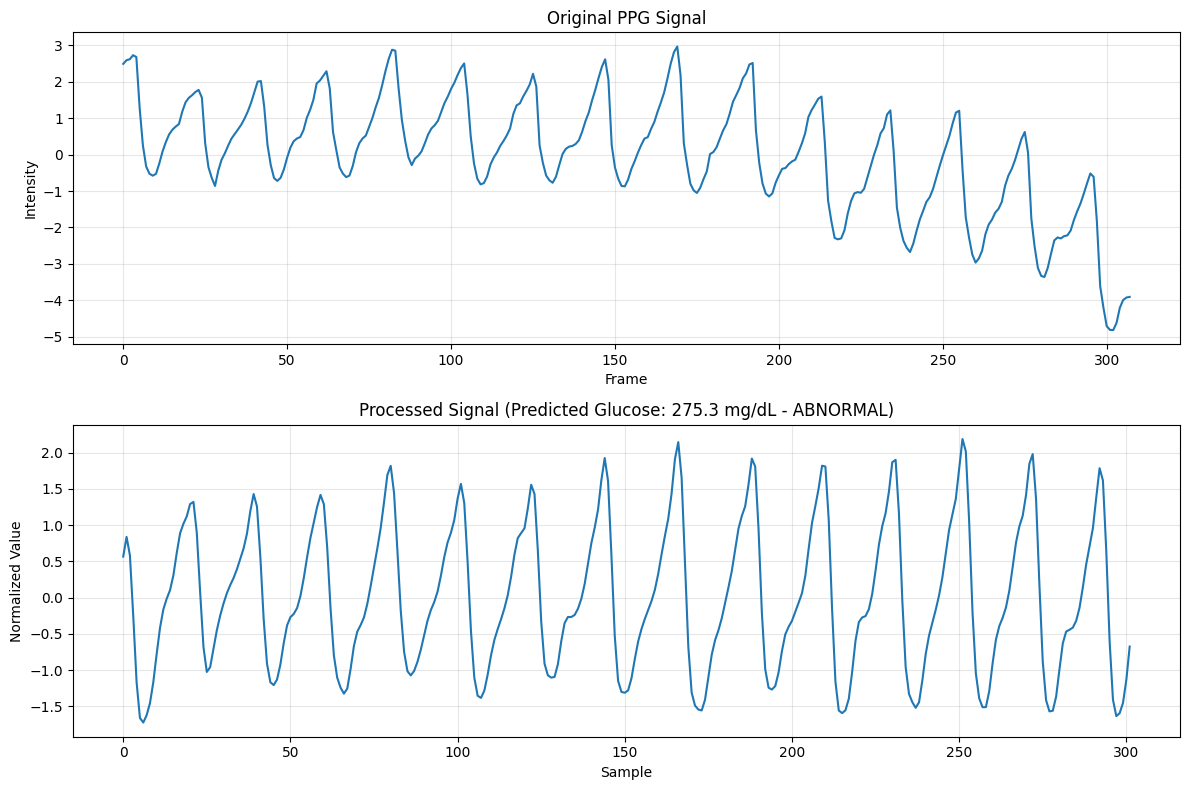

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle
import os

def extract_ppg_from_video(video_path, start_time=0, duration=30, roi_percent=0.5):
    """
    Extract PPG signal from video with improved region of interest selection
    
    Parameters:
    -----------
    video_path : str
        Path to the video file
    start_time : int
        Start time in seconds
    duration : int
        Duration to extract in seconds
    roi_percent : float
        Percentage of the center of the frame to use (0-1)
    
    Returns:
    --------
    ppg_signal : numpy.ndarray
        Extracted PPG signal
    sampling_rate : float
        Sampling rate of the extracted signal
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")
    
    # Get video properties
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video loaded: {video_path}")
    print(f"Frame rate: {frame_rate:.2f} fps")
    print(f"Resolution: {frame_width}x{frame_height}")
    print(f"Total frames: {total_frames}")
    
    # Calculate frame numbers
    start_frame = int(start_time * frame_rate)
    end_frame = min(int((start_time + duration) * frame_rate), total_frames)
    
    # Calculate ROI coordinates (center of the frame)
    roi_size = int(min(frame_width, frame_height) * roi_percent)
    x_start = (frame_width - roi_size) // 2
    y_start = (frame_height - roi_size) // 2
    
    # Skip to start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Extract red channel values
    red_channel_values = []
    green_channel_values = []  # Also extract green channel as it might have better signal
    frame_count = 0
    
    while cap.isOpened():
        frame_idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        if frame_idx >= end_frame:
            break
            
        ret, frame = cap.read()
        if not ret:
            break
            
        # Extract ROI
        roi = frame[y_start:y_start+roi_size, x_start:x_start+roi_size]
        
        # Extract channels (OpenCV loads as BGR)
        red_channel = roi[:, :, 2]  
        green_channel = roi[:, :, 1]
        
        # Calculate average intensities
        red_avg = np.mean(red_channel)
        green_avg = np.mean(green_channel)
        
        red_channel_values.append(red_avg)
        green_channel_values.append(green_avg)
        frame_count += 1
    
    cap.release()
    
    # Convert to NumPy arrays
    red_signal = np.array(red_channel_values)
    green_signal = np.array(green_channel_values)
    
    # Select the channel with the strongest pulsatile component
    # (typically green channel has better PPG signal)
    red_signal_var = np.var(red_signal)
    green_signal_var = np.var(green_signal)
    
    if green_signal_var > red_signal_var:
        ppg_signal = green_signal
        print(f"Using GREEN channel (variance: {green_signal_var:.2f})")
    else:
        ppg_signal = red_signal
        print(f"Using RED channel (variance: {red_signal_var:.2f})")
    
    print(f"Extracted {len(ppg_signal)} frames of PPG data")
    
    # Normalize the signal
    ppg_signal = (ppg_signal - np.mean(ppg_signal))
    
    return ppg_signal, frame_rate

def bandpass_filter(signal, lowcut=0.5, highcut=8.0, fs=30, order=4):
    """
    Apply a band-pass filter to focus on frequencies in the PPG range.
    
    Parameters:
    -----------
    signal : numpy.ndarray
        Input signal
    lowcut : float
        Lower cutoff frequency (Hz)
    highcut : float
        Upper cutoff frequency (Hz)
    fs : float
        Sampling frequency (Hz)
    order : int
        Filter order
    
    Returns:
    --------
    filtered_signal : numpy.ndarray
        Filtered signal
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def preprocess_signal_exactly_like_training(ppg_signal, original_sampling_rate, target_length=302):
    """
    Preprocess the PPG signal using the exact same pipeline as in training.
    
    Parameters:
    -----------
    ppg_signal : numpy.ndarray
        Raw PPG signal
    original_sampling_rate : float
        Original sampling rate of the signal
    target_length : int
        Target length for the model
        
    Returns:
    --------
    processed_signal : numpy.ndarray
        Processed signal ready for the model
    """
    # Step 1: Standardize the signal
    normalized_signal = (ppg_signal - np.mean(ppg_signal)) / np.std(ppg_signal)
    
    # Step 2: Apply bandpass filter (0.5-8 Hz, matches your training code)
    target_sampling_rate = 30  # Your model expected sampling rate
    filtered_signal = bandpass_filter(
        normalized_signal, 
        lowcut=0.5, 
        highcut=8, 
        fs=original_sampling_rate, 
        order=4
    )
    
    # Step 3: Resample to target sampling rate (30 Hz)
    num_samples = int(len(filtered_signal) * (target_sampling_rate / original_sampling_rate))
    resampled_signal = resample(filtered_signal, num_samples)
    
    # Step 4: Apply another bandpass filter at the target sampling rate
    filtered_signal = bandpass_filter(
        resampled_signal, 
        lowcut=0.5, 
        highcut=8, 
        fs=target_sampling_rate, 
        order=4
    )
    
    # Step 5: Normalize again
    processed_signal = (filtered_signal - np.mean(filtered_signal)) / np.std(filtered_signal)
    
    # Step 6: Ensure correct length for model
    if len(processed_signal) > target_length:
        # Take the middle portion
        start_idx = (len(processed_signal) - target_length) // 2
        processed_signal = processed_signal[start_idx:start_idx+target_length]
    elif len(processed_signal) < target_length:
        # Pad with zeros
        pad_amount = target_length - len(processed_signal)
        processed_signal = np.pad(processed_signal, (0, pad_amount), 'constant')
    
    return processed_signal

def predict_glucose_with_model(model_path, scaler_path, processed_signal):
    """
    Predict glucose level using the model.
    
    Parameters:
    -----------
    model_path : str
        Path to the trained model
    scaler_path : str
        Path to the scaler
    processed_signal : numpy.ndarray
        Processed PPG signal
        
    Returns:
    --------
    predicted_glucose : float
        Predicted glucose level in mg/dL
    """
    # Load model
    model = load_model(model_path)
    
    # Load scaler
    with open(scaler_path, 'rb') as f:
        scaler_y = pickle.load(f)
    
    # Prepare input for the model (reshape to [batch, sequence_length, features])
    X = np.expand_dims(processed_signal, axis=-1)  # Add feature dimension
    X = np.expand_dims(X, axis=0)  # Add batch dimension
    
    # Make prediction
    y_pred = model.predict(X)
    
    # Convert back to original scale
    predicted_glucose = scaler_y.inverse_transform(y_pred)[0][0]
    
    return predicted_glucose

def visualize_signal_processing(original_signal, processed_signal, predicted_glucose, save_path=None):
    """
    Visualize the signal processing steps.
    
    Parameters:
    -----------
    original_signal : numpy.ndarray
        Original signal
    processed_signal : numpy.ndarray
        Processed signal
    predicted_glucose : float
        Predicted glucose level
    save_path : str
        Path to save the visualization
    """
    plt.figure(figsize=(12, 8))
    
    # Original signal
    plt.subplot(2, 1, 1)
    plt.plot(original_signal)
    plt.title('Original PPG Signal')
    plt.xlabel('Frame')
    plt.ylabel('Intensity')
    plt.grid(alpha=0.3)
    
    # Processed signal
    plt.subplot(2, 1, 2)
    plt.plot(processed_signal)
    normal_range = "NORMAL" if 70 <= predicted_glucose <= 180 else "ABNORMAL"
    plt.title(f'Processed Signal (Predicted Glucose: {predicted_glucose:.1f} mg/dL - {normal_range})')
    plt.xlabel('Sample')
    plt.ylabel('Normalized Value')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

def predict_from_video(video_path, model_path, scaler_path, target_length=302, visualization_path=None):
    """
    Complete prediction pipeline from video to glucose level.
    
    Parameters:
    -----------
    video_path : str
        Path to the video file
    model_path : str
        Path to the trained model
    scaler_path : str
        Path to the scaler
    target_length : int
        Target sequence length for the model
    visualization_path : str
        Path to save the visualization
        
    Returns:
    --------
    predicted_glucose : float
        Predicted glucose level in mg/dL
    """
    print("1. Extracting PPG signal from video...")
    ppg_signal, sampling_rate = extract_ppg_from_video(video_path)
    
    print(f"2. Processing signal (sampling rate: {sampling_rate:.2f} Hz)...")
    processed_signal = preprocess_signal_exactly_like_training(
        ppg_signal, 
        original_sampling_rate=sampling_rate,
        target_length=target_length
    )
    
    print("3. Predicting glucose level...")
    predicted_glucose = predict_glucose_with_model(
        model_path,
        scaler_path,
        processed_signal
    )
    
    print(f"4. Result: Predicted glucose level: {predicted_glucose:.1f} mg/dL")
    normal_range = "NORMAL" if 70 <= predicted_glucose <= 180 else "ABNORMAL"
    print(f"   Range: {normal_range}")
    
    print("5. Generating visualization...")
    visualize_signal_processing(
        ppg_signal,
        processed_signal,
        predicted_glucose,
        save_path=visualization_path
    )
    
    return predicted_glucose

# Example usage:
video_path = "PPG_Unseen/PPGDinner.mp4"
model_path = "optimized_lstm_model3.h5"
scaler_path = "glucose_ensemble/scaler_y.pkl"
visualization_path = "ppg_visualization.png"
predicted_glucose = predict_from_video(video_path, model_path, scaler_path, visualization_path=visualization_path)

1. Extracting PPG signal from video...
Video loaded: PPG_Unseen/PPG09.mp4
Frame rate: 30.00 fps
Resolution: 1280x720
Total frames: 930
Using RED channel (variance: 29.24)
Extracted 900 frames of PPG data
2. Processing signal (sampling rate: 30.00 Hz)...
After standardization - Mean: 0.0000, Std: 1.0000
After bandpass filter - Mean: -0.0015, Std: 0.2187
After resampling - Mean: -0.0014, Std: 0.2211
Final processed signal - Mean: -0.0000, Std: 1.0000
   Estimated heart rate: 146.3 BPM
   Signal quality: Good
3. Predicting glucose level with safety clamping...
1/1 [==============================] - 1s 1s/step
4. Result: Predicted glucose level: 183.0 mg/dL
   Original unclamped prediction: 233.6 mg/dL
   (Value clamped to training range: 88-183 mg/dL)
   Clinical range: ABNORMAL
5. Generating visualization...


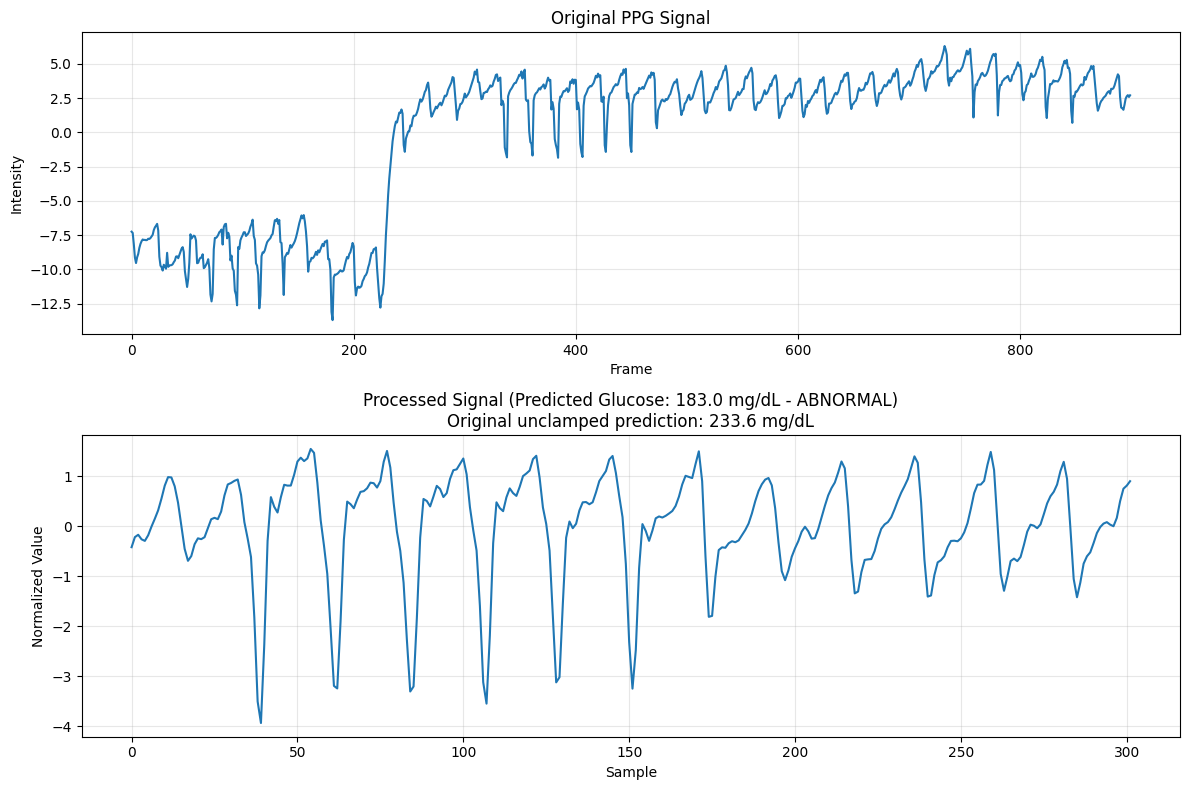

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle
import os

def extract_ppg_from_video(video_path, start_time=0, duration=30, roi_percent=0.5):
    """
    Extract PPG signal from video with improved region of interest selection
    
    Parameters:
    -----------
    video_path : str
        Path to the video file
    start_time : int
        Start time in seconds
    duration : int
        Duration to extract in seconds
    roi_percent : float
        Percentage of the center of the frame to use (0-1)
    
    Returns:
    --------
    ppg_signal : numpy.ndarray
        Extracted PPG signal
    sampling_rate : float
        Sampling rate of the extracted signal
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")
    
    # Get video properties
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video loaded: {video_path}")
    print(f"Frame rate: {frame_rate:.2f} fps")
    print(f"Resolution: {frame_width}x{frame_height}")
    print(f"Total frames: {total_frames}")
    
    # Calculate frame numbers
    start_frame = int(start_time * frame_rate)
    end_frame = min(int((start_time + duration) * frame_rate), total_frames)
    
    # Calculate ROI coordinates (center of the frame)
    roi_size = int(min(frame_width, frame_height) * roi_percent)
    x_start = (frame_width - roi_size) // 2
    y_start = (frame_height - roi_size) // 2
    
    # Skip to start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Extract red channel values
    red_channel_values = []
    green_channel_values = []  # Also extract green channel as it might have better signal
    frame_count = 0
    
    while cap.isOpened():
        frame_idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        if frame_idx >= end_frame:
            break
            
        ret, frame = cap.read()
        if not ret:
            break
            
        # Extract ROI
        roi = frame[y_start:y_start+roi_size, x_start:x_start+roi_size]
        
        # Extract channels (OpenCV loads as BGR)
        red_channel = roi[:, :, 2]  
        green_channel = roi[:, :, 1]
        
        # Calculate average intensities
        red_avg = np.mean(red_channel)
        green_avg = np.mean(green_channel)
        
        red_channel_values.append(red_avg)
        green_channel_values.append(green_avg)
        frame_count += 1
    
    cap.release()
    
    # Convert to NumPy arrays
    red_signal = np.array(red_channel_values)
    green_signal = np.array(green_channel_values)
    
    # Select the channel with the strongest pulsatile component
    # (typically green channel has better PPG signal)
    red_signal_var = np.var(red_signal)
    green_signal_var = np.var(green_signal)
    
    if green_signal_var > red_signal_var:
        ppg_signal = green_signal
        print(f"Using GREEN channel (variance: {green_signal_var:.2f})")
    else:
        ppg_signal = red_signal
        print(f"Using RED channel (variance: {red_signal_var:.2f})")
    
    print(f"Extracted {len(ppg_signal)} frames of PPG data")
    
    # Normalize the signal
    ppg_signal = (ppg_signal - np.mean(ppg_signal))
    
    return ppg_signal, frame_rate

def bandpass_filter(signal, lowcut=0.5, highcut=8.0, fs=30, order=4):
    """
    Apply a band-pass filter to focus on frequencies in the PPG range.
    
    Parameters:
    -----------
    signal : numpy.ndarray
        Input signal
    lowcut : float
        Lower cutoff frequency (Hz)
    highcut : float
        Upper cutoff frequency (Hz)
    fs : float
        Sampling frequency (Hz)
    order : int
        Filter order
    
    Returns:
    --------
    filtered_signal : numpy.ndarray
        Filtered signal
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def preprocess_signal_exactly_like_training(ppg_signal, original_sampling_rate, target_length=302):
    """
    Preprocess the PPG signal using the exact same pipeline as in training.
    
    Parameters:
    -----------
    ppg_signal : numpy.ndarray
        Raw PPG signal
    original_sampling_rate : float
        Original sampling rate of the signal
    target_length : int
        Target length for the model
        
    Returns:
    --------
    processed_signal : numpy.ndarray
        Processed signal ready for the model
    """

    # Step 1: Standardize the signal
    normalized_signal = (ppg_signal - np.mean(ppg_signal)) / np.std(ppg_signal)
    
    # Step 2: Apply bandpass filter (0.5-8 Hz, matches your training code)
    target_sampling_rate = 30  # Your model expected sampling rate
    filtered_signal = bandpass_filter(
        normalized_signal, 
        lowcut=0.5, 
        highcut=8, 
        fs=original_sampling_rate, 
        order=4
    )
    
    # Step 3: Resample to target sampling rate (30 Hz)
    num_samples = int(len(filtered_signal) * (target_sampling_rate / original_sampling_rate))
    resampled_signal = resample(filtered_signal, num_samples)
    
    # Step 4: Apply another bandpass filter at the target sampling rate
    filtered_signal = bandpass_filter(
        resampled_signal, 
        lowcut=0.5, 
        highcut=8, 
        fs=target_sampling_rate, 
        order=4
    )
    
    # Step 5: Normalize again
    processed_signal = (filtered_signal - np.mean(filtered_signal)) / np.std(filtered_signal)
     # After standardizing
    print(f"After standardization - Mean: {np.mean(normalized_signal):.4f}, Std: {np.std(normalized_signal):.4f}")
    
    # After filtering
    print(f"After bandpass filter - Mean: {np.mean(filtered_signal):.4f}, Std: {np.std(filtered_signal):.4f}")
    
    # After resampling
    print(f"After resampling - Mean: {np.mean(resampled_signal):.4f}, Std: {np.std(resampled_signal):.4f}")
    
    # Final processed signal
    print(f"Final processed signal - Mean: {np.mean(processed_signal):.4f}, Std: {np.std(processed_signal):.4f}")
    
    # Step 6: Ensure correct length for model
    if len(processed_signal) > target_length:
        # Take the middle portion
        start_idx = (len(processed_signal) - target_length) // 2
        processed_signal = processed_signal[start_idx:start_idx+target_length]
    elif len(processed_signal) < target_length:
        # Pad with zeros
        pad_amount = target_length - len(processed_signal)
        processed_signal = np.pad(processed_signal, (0, pad_amount), 'constant')
    
    return processed_signal


def safe_predict_glucose_with_model(model_path, scaler_path, processed_signal, 
                                   min_glucose=88, max_glucose=183):
    """
    Predict glucose level using the model with safety clamping to training range.
    
    Parameters:
    -----------
    model_path : str
        Path to the trained model
    scaler_path : str
        Path to the scaler
    processed_signal : numpy.ndarray
        Processed PPG signal
    min_glucose : float
        Minimum allowed glucose prediction (from training data)
    max_glucose : float
        Maximum allowed glucose prediction (from training data)
        
    Returns:
    --------
    predicted_glucose : float
        Predicted glucose level in mg/dL, clamped to training range
    unclamped_glucose : float
        Raw predicted glucose level before clamping
    """
    # Load model
    model = load_model(model_path)
    
    # Load scaler
    with open(scaler_path, 'rb') as f:
        scaler_y = pickle.load(f)
    
    # Prepare input for the model (reshape to [batch, sequence_length, features])
    X = np.expand_dims(processed_signal, axis=-1)  # Add feature dimension
    X = np.expand_dims(X, axis=0)  # Add batch dimension
    
    # Make prediction
    y_pred = model.predict(X)
    
    # Convert back to original scale
    unclamped_glucose = scaler_y.inverse_transform(y_pred)[0][0]
    
    # Clamp to training range
    predicted_glucose = max(min_glucose, min(max_glucose, unclamped_glucose))
    
    return predicted_glucose, unclamped_glucose

def visualize_signal_processing(original_signal, processed_signal, predicted_glucose, 
                               unclamped_glucose=None, save_path=None):
    """
    Visualize the signal processing steps.
    
    Parameters:
    -----------
    original_signal : numpy.ndarray
        Original signal
    processed_signal : numpy.ndarray
        Processed signal
    predicted_glucose : float
        Predicted glucose level (clamped)
    unclamped_glucose : float
        Unclamped glucose prediction (optional)
    save_path : str
        Path to save the visualization
    """
    plt.figure(figsize=(12, 8))
    
    # Original signal
    plt.subplot(2, 1, 1)
    plt.plot(original_signal)
    plt.title('Original PPG Signal')
    plt.xlabel('Frame')
    plt.ylabel('Intensity')
    plt.grid(alpha=0.3)
    
    # Processed signal
    plt.subplot(2, 1, 2)
    plt.plot(processed_signal)
    normal_range = "NORMAL" if 70 <= predicted_glucose <= 180 else "ABNORMAL"
    
    if unclamped_glucose is not None and abs(unclamped_glucose - predicted_glucose) > 1:
        title = f'Processed Signal (Predicted Glucose: {predicted_glucose:.1f} mg/dL - {normal_range})\n'
        title += f'Original unclamped prediction: {unclamped_glucose:.1f} mg/dL'
    else:
        title = f'Processed Signal (Predicted Glucose: {predicted_glucose:.1f} mg/dL - {normal_range})'
        
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Normalized Value')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

def calculate_heart_rate(processed_signal, sampling_rate=30):
    """
    Calculate heart rate from processed PPG signal.
    
    Parameters:
    -----------
    processed_signal : numpy.ndarray
        Processed PPG signal
    sampling_rate : float
        Sampling rate in Hz
        
    Returns:
    --------
    heart_rate : float
        Estimated heart rate in BPM
    """
    from scipy.signal import find_peaks
    
    # Find peaks in the signal
    peaks, _ = find_peaks(processed_signal, distance=sampling_rate/3)
    
    if len(peaks) < 2:
        return None
    
    # Calculate average peak-to-peak interval
    peak_intervals = np.diff(peaks)
    avg_interval = np.mean(peak_intervals)
    
    # Convert to BPM
    heart_rate = 60 * sampling_rate / avg_interval
    
    return heart_rate

def assess_signal_quality(processed_signal, heart_rate):
    """
    Assess the quality of the processed PPG signal.
    
    Parameters:
    -----------
    processed_signal : numpy.ndarray
        Processed PPG signal
    heart_rate : float
        Calculated heart rate
        
    Returns:
    --------
    quality : str
        Signal quality assessment ('Good', 'Fair', 'Poor')
    """
    # Check if heart rate is in normal range
    if heart_rate is None:
        return "Poor"
    
    hr_normal = 40 <= heart_rate <= 200
    
    # Calculate signal-to-noise ratio (simplified)
    from scipy.fft import fft, fftfreq
    
    # Get frequency domain
    n = len(processed_signal)
    yf = np.abs(fft(processed_signal))
    xf = fftfreq(n, 1/30)[:n//2]
    yf = yf[:n//2]
    
    # Find peak frequency 
    peak_idx = np.argmax(yf)
    peak_freq = xf[peak_idx]
    peak_magnitude = yf[peak_idx]
    
    # Estimate noise as average magnitude outside heart rate region
    hr_freq = heart_rate / 60  # Convert BPM to Hz
    mask = np.logical_or(xf < hr_freq*0.8, xf > hr_freq*1.2)
    noise_magnitude = np.mean(yf[mask])
    
    if noise_magnitude > 0:
        snr = peak_magnitude / noise_magnitude
    else:
        snr = 0
    
    # Assess quality
    if hr_normal and snr > 5:
        return "Good"
    elif hr_normal and snr > 2:
        return "Fair"
    else:
        return "Poor"

def predict_from_video(video_path, model_path, scaler_path, target_length=302, 
                      visualization_path=None, min_glucose=88, max_glucose=183):
    """
    Complete prediction pipeline from video to glucose level.
    
    Parameters:
    -----------
    video_path : str
        Path to the video file
    model_path : str
        Path to the trained model
    scaler_path : str
        Path to the scaler
    target_length : int
        Target sequence length for the model
    visualization_path : str
        Path to save the visualization
    min_glucose : float
        Minimum allowed glucose prediction (from training data)
    max_glucose : float
        Maximum allowed glucose prediction (from training data)
        
    Returns:
    --------
    predicted_glucose : float
        Predicted glucose level in mg/dL
    """
    print("1. Extracting PPG signal from video...")
    ppg_signal, sampling_rate = extract_ppg_from_video(video_path)
    
    print(f"2. Processing signal (sampling rate: {sampling_rate:.2f} Hz)...")
    processed_signal = preprocess_signal_exactly_like_training(
        ppg_signal, 
        original_sampling_rate=sampling_rate,
        target_length=target_length
    )
    
    # Calculate heart rate and assess signal quality
    heart_rate = calculate_heart_rate(processed_signal)
    if heart_rate is not None:
        quality = assess_signal_quality(processed_signal, heart_rate)
        print(f"   Estimated heart rate: {heart_rate:.1f} BPM")
        print(f"   Signal quality: {quality}")
    else:
        print("   Could not detect reliable heart rate - signal quality may be poor")
    
    print("3. Predicting glucose level with safety clamping...")
    predicted_glucose, unclamped_glucose = safe_predict_glucose_with_model(
        model_path,
        scaler_path,
        processed_signal,
        min_glucose=min_glucose,
        max_glucose=max_glucose
    )
    
    print(f"4. Result: Predicted glucose level: {predicted_glucose:.1f} mg/dL")
    if abs(unclamped_glucose - predicted_glucose) > 1:
        print(f"   Original unclamped prediction: {unclamped_glucose:.1f} mg/dL")
        print(f"   (Value clamped to training range: {min_glucose}-{max_glucose} mg/dL)")
    
    normal_range = "NORMAL" if 70 <= predicted_glucose <= 180 else "ABNORMAL"
    print(f"   Clinical range: {normal_range}")
    
    print("5. Generating visualization...")
    visualize_signal_processing(
        ppg_signal,
        processed_signal,
        predicted_glucose,
        unclamped_glucose,
        save_path=visualization_path
    )
    
    return predicted_glucose, unclamped_glucose



video_path = "PPG_Unseen/PPG09.mp4"
model_path = "optimized_lstm_model3.h5"
scaler_path = "glucose_ensemble/scaler_y.pkl"
visualization_path = "ppg_visualization.png"
    
    # Run prediction with safety clamping to training data range
predicted_glucose, unclamped_glucose = predict_from_video(
video_path,
model_path,
scaler_path,
visualization_path=visualization_path,
min_glucose=88,    # From training data statistics
max_glucose=183    # From training data statistics
    )

In [144]:
def extract_ppg_from_video(video_path, target_length=302, target_fps=30):
    """
    Extracts and processes PPG signal from a video file using the same pipeline as training.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Error opening video file: {video_path}")

    # Get video properties safely
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Ensure we have a valid frame rate
    if original_fps <= 0:
        print(f"Warning: Invalid frame rate detected ({original_fps}), using default value of {target_fps}.")
        original_fps = target_fps
    
    # Extract pixel intensities
    red_channel_values = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        # Extract red channel (BGR format, so index 2)
        red_channel = frame[:, :, 2]
        avg_intensity = np.mean(red_channel)
        red_channel_values.append(avg_intensity)
    
    cap.release()
    
    # Convert to numpy array
    ppg_signal = np.array(red_channel_values)
    
    if len(ppg_signal) == 0:
        raise ValueError("Extracted PPG signal is empty")
    
    # Apply the exact same preprocessing as in your training code
    # Step 1: Standardize the signal
    normalized_signal = (ppg_signal - np.mean(ppg_signal)) / np.std(ppg_signal)
    
    # Step 2: Apply bandpass filter (0.5-8 Hz, matching training code)
    nyquist = 0.5 * original_fps
    low = 0.5 / nyquist
    high = 8.0 / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, normalized_signal)
    
    # Step 3: Resample to target length
    resampled_signal = resample(filtered_signal, target_length)
    
    # Step 4: Normalize again
    processed_signal = (resampled_signal - np.mean(resampled_signal)) / np.std(resampled_signal)
    
    return processed_signal

In [145]:
def predict_glucose_from_video(model, video_path, scaler_y, target_length=302):
    """
    Predicts glucose level from a video file.
    
    Parameters:
        model (tf.keras.Model): Trained glucose prediction model.
        video_path (str): Path to the input video file.
        scaler_y (MinMaxScaler): Scaler used for glucose level normalization.
        
    Returns:
        float: Predicted glucose level.
    """
    # Extract PPG signal with proper preprocessing
    ppg_signal = extract_ppg_from_video(video_path, target_length=target_length)
    
    # Reshape for LSTM model input [batch, sequence_length, features]
    # No need to use scaler_X since we're already normalizing in extract_ppg_from_video
    ppg_signal = np.expand_dims(ppg_signal, axis=0)  # Add batch dimension
    ppg_signal = np.expand_dims(ppg_signal, axis=2)  # Add feature dimension
    
    # Make prediction
    predicted_glucose = model.predict(ppg_signal)
    
    # Convert back to original glucose scale
    predicted_glucose = scaler_y.inverse_transform(predicted_glucose)[0][0]
    
    print(f"Predicted Glucose Level: {predicted_glucose:.2f} mg/dL")
    return predicted_glucose
# Example usage
video_path = "PPG_Unseen/PPGnow.mp4"
predicted_glucose = predict_glucose_from_video(model, video_path, scaler_y)


1/1 [==============================] - 0s 104ms/step
Predicted Glucose Level: 102.57 mg/dL


In [146]:
# Ensure correct shape for CNN-GRU
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)  # (batch_size, time_steps, 1)


# Make predictions
y_pred_normalized = model.predict(X_test)  

# Convert back to original glucose scale
y_pred = scaler_y.inverse_transform(y_pred_normalized).flatten()  # <-- Fix applied

# Debugging prints
print(f"Test dataset shape: {X_test.shape}")  # Check input shape before model prediction
print(f"Raw model predictions: {y_pred_normalized[:5]}")  # Print first 5 values
print(f"Actual Glucose (before scaling): {y_test[:5]}")  # Check first 5 true glucose values
print(f"Predicted Glucose (after scaling back): {y_pred[:5]}")  # Now this is properly defined


2/2 [==============================] - 0s 64ms/step
Test dataset shape: (54, 302, 1)
Raw model predictions: [[0.166815  ]
 [0.1653561 ]
 [0.12867568]
 [0.24253505]
 [0.2563434 ]]
Actual Glucose (before scaling): [0.18947368 0.18947368 0.08421053 0.28421053 0.23157895]
Predicted Glucose (after scaling back): [103.84743  103.70883  100.22419  111.04083  112.352615]


In [147]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae:.2f} mg/dL")
print(f"Test RMSE: {rmse:.2f} mg/dL")
print(f"Test R² Score: {r2:.4f}")


Test MAE: 112.78 mg/dL
Test RMSE: 113.82 mg/dL
Test R² Score: -217863.0089


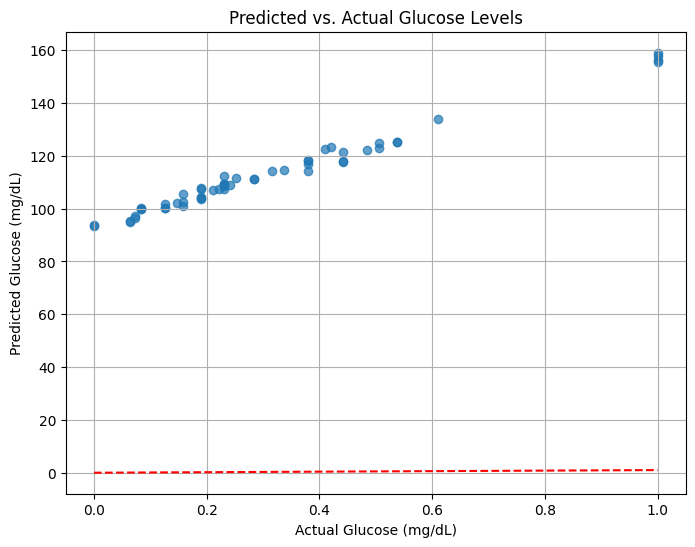

In [148]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual Glucose (mg/dL)")
plt.ylabel("Predicted Glucose (mg/dL)")
plt.title("Predicted vs. Actual Glucose Levels")
plt.grid(True)
plt.show()


In [149]:
print(f"Min glucose in dataset: {np.min(y_test)}")
print(f"Max glucose in dataset: {np.max(y_test)}")


Min glucose in dataset: 0.0
Max glucose in dataset: 1.0


In [150]:
print(f"Predicted Glucose (before inverse transform): {y_pred_normalized[:5]}")
print(f"Predicted Glucose (after inverse transform): {y_pred[:5]}")


Predicted Glucose (before inverse transform): [[0.166815  ]
 [0.1653561 ]
 [0.12867568]
 [0.24253505]
 [0.2563434 ]]
Predicted Glucose (after inverse transform): [103.84743  103.70883  100.22419  111.04083  112.352615]


In [151]:
print(f"Mean Predicted Glucose: {np.mean(y_pred)}")
print(f"Standard Deviation of Predictions: {np.std(y_pred)}")


Mean Predicted Glucose: 113.09410858154297
Standard Deviation of Predictions: 15.556526184082031


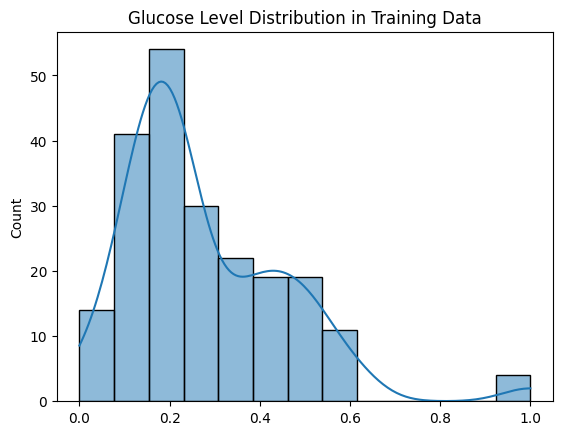

In [152]:
import seaborn as sns
sns.histplot(y_train, kde=True)
plt.title("Glucose Level Distribution in Training Data")
plt.show()


In [153]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verify the new distribution
sns.histplot(y_train_resampled, kde=True)
plt.title("Balanced Glucose Level Distribution")
plt.show()


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

Loading model from glucose_cnn_gru_model.h5...
Loading glucose scaler from glucose_ensemble/scaler_y.pkl...
Loading data from processed_ppg_data.pkl...
Splitting data into train/test sets...
Making predictions with CNN-GRU model...
2/2 [==============================] - 1s 106ms/step
Test MAE: 23.73 mg/dL
Test RMSE: 31.21 mg/dL
Test R²: -1.6918
Performing Clarke Error Grid analysis...

Clarke Error Grid Analysis Results:
Zone A: 63.0% (34/54 points)
Zone B: 3.7% (2/54 points)
Zone C: 0.0% (0/54 points)
Zone D: 3.7% (2/54 points)
Zone E: 29.6% (16/54 points)

Clinical Acceptability (A+B): 66.7%


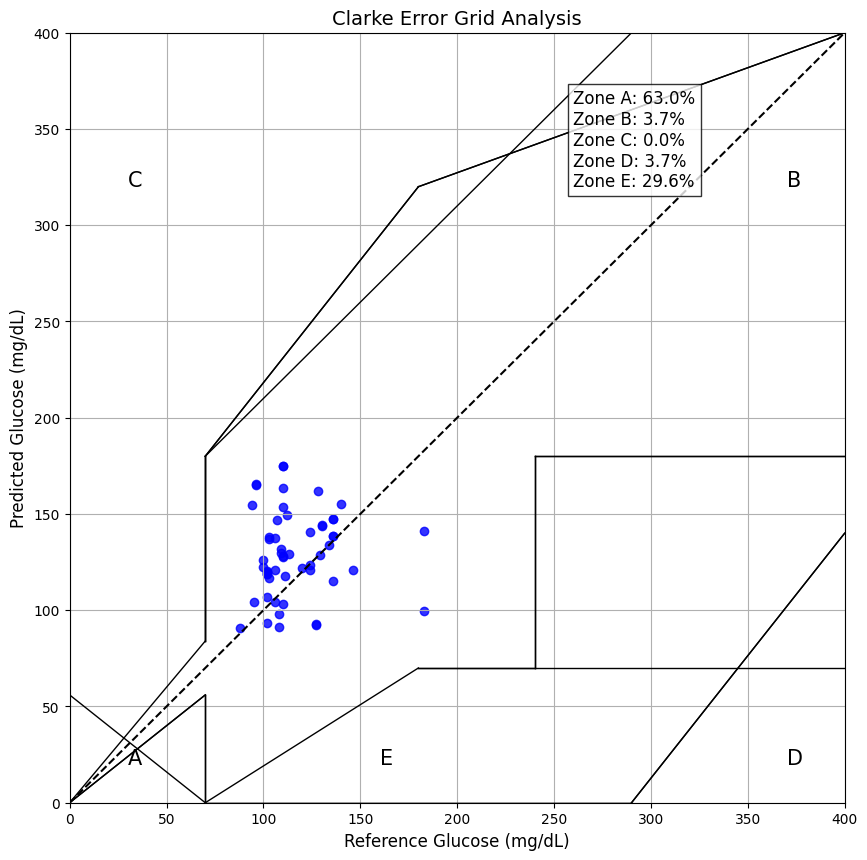

<Figure size 1200x1000 with 0 Axes>

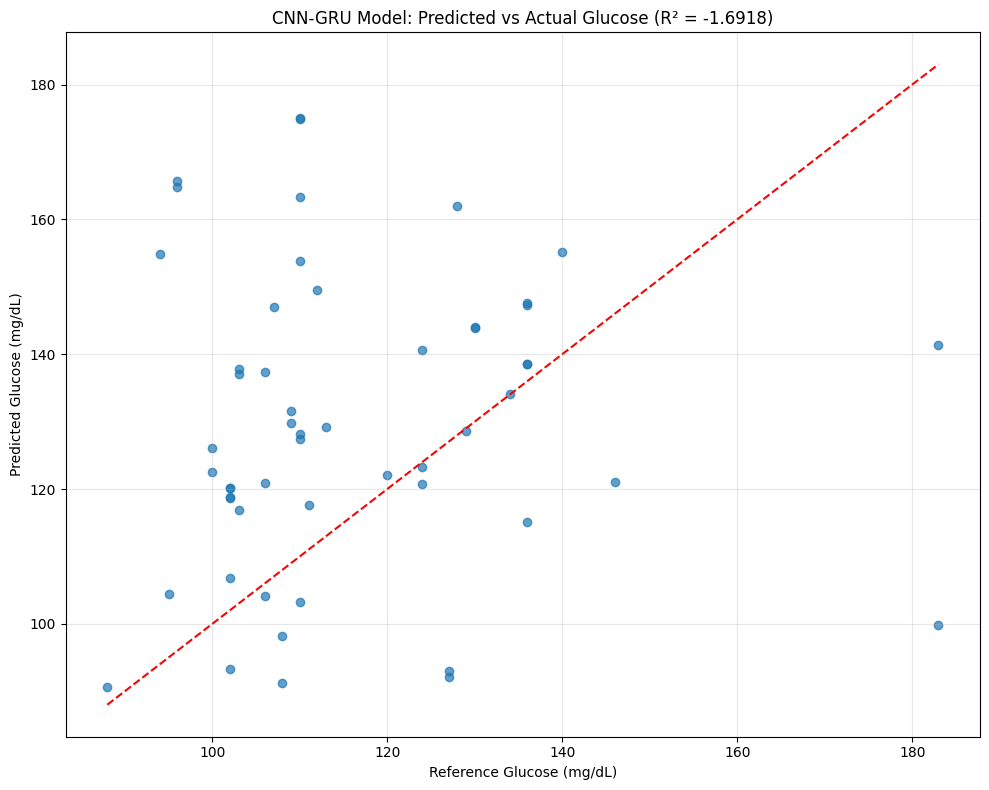

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def clarke_error_grid(reference_values, prediction_values):
    """
    Implements the Clarke Error Grid Analysis
    
    Parameters:
        reference_values: Array of actual glucose measurements
        prediction_values: Array of predicted glucose measurements
        
    Returns:
        Tuple containing:
        - Figure with the Clarke Error Grid
        - Array with the number of points in each zone
    """
    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Set limits for the axes
    ax.set_xlim([0, 400])
    ax.set_ylim([0, 400])
    
    # Add grid lines
    ax.grid(True)
    
    # Add diagonal line
    ax.plot([0, 400], [0, 400], 'k--')
    
    # Add zone boundaries
    # Zone A - upper and lower boundaries
    ax.plot([0, 70], [0, 84], 'k-', linewidth=1.0)  # lower A
    ax.plot([70, 70], [84, 180], 'k-', linewidth=1.0)
    ax.plot([70, 180], [180, 320], 'k-', linewidth=1.0)
    ax.plot([180, 400], [320, 400], 'k-', linewidth=1.0)
    
    ax.plot([0, 70], [0, 56], 'k-', linewidth=1.0)  # upper A
    ax.plot([70, 70], [56, 0], 'k-', linewidth=1.0)
    ax.plot([70, 290], [0, 0], 'k-', linewidth=1.0)
    ax.plot([290, 400], [0, 140], 'k-', linewidth=1.0)
    
    # Zone B - upper and lower boundaries
    ax.plot([0, 70], [56, 0], 'k-', linewidth=1.0)  # lower B
    ax.plot([70, 290], [0, 0], 'k-', linewidth=1.0)
    ax.plot([290, 400], [0, 140], 'k-', linewidth=1.0)
    
    ax.plot([70, 70], [84, 180], 'k-', linewidth=1.0)  # upper B
    ax.plot([70, 180], [180, 320], 'k-', linewidth=1.0)
    ax.plot([180, 400], [320, 400], 'k-', linewidth=1.0)
    
    # Zone C
    ax.plot([0, 70], [0, 56], 'k-', linewidth=1.0)
    ax.plot([70, 70], [56, 0], 'k-', linewidth=1.0)
    
    ax.plot([70, 70], [84, 180], 'k-', linewidth=1.0)
    ax.plot([70, 290], [180, 400], 'k-', linewidth=1.0)
    
    # Zone D
    ax.plot([180, 400], [70, 70], 'k-', linewidth=1.0)
    ax.plot([240, 240], [70, 180], 'k-', linewidth=1.0)
    ax.plot([240, 400], [180, 180], 'k-', linewidth=1.0)
    
    # Zone E
    ax.plot([70, 180], [0, 70], 'k-', linewidth=1.0)
    ax.plot([180, 240], [70, 70], 'k-', linewidth=1.0)
    ax.plot([240, 240], [70, 180], 'k-', linewidth=1.0)
    ax.plot([240, 400], [180, 180], 'k-', linewidth=1.0)
    
    # Add zone labels
    ax.text(30, 20, "A", fontsize=15)
    ax.text(30, 320, "C", fontsize=15)
    ax.text(370, 20, "D", fontsize=15)
    ax.text(370, 320, "B", fontsize=15)
    ax.text(160, 20, "E", fontsize=15)
    
    # Add titles and labels
    ax.set_title("Clarke Error Grid Analysis", fontsize=14)
    ax.set_xlabel("Reference Glucose (mg/dL)", fontsize=12)
    ax.set_ylabel("Predicted Glucose (mg/dL)", fontsize=12)
    
    # Plot the data points
    ax.scatter(reference_values, prediction_values, c='blue', alpha=0.8)
    
    # Count points in each zone
    zones = np.zeros(5)  # A, B, C, D, E
    
    for i in range(len(reference_values)):
        ref = reference_values[i]
        pred = prediction_values[i]
        
        # Zone A: Clinically accurate
        if (ref <= 70 and pred <= 70) or (0.8 * ref <= pred <= 1.2 * ref):
            zones[0] += 1
        
        # Zone B: Clinically acceptable
        elif ((ref >= 180 and pred >= 70 and pred <= 180) or 
              (ref <= 70 and pred >= 70 and pred <= 180) or
              (ref >= 70 and ref <= 290 and pred >= ref + 110) or
              (ref >= 130 and ref <= 180 and pred <= (7/5) * ref - 182)):
            zones[1] += 1
        
        # Zone C: Overcorrection
        elif ((ref >= 180 and 0 <= pred <= 70) or 
              (ref <= 70 and pred >= 180)):
            zones[2] += 1
        
        # Zone D: Dangerous failure to detect
        elif ((ref >= 70 and pred <= ref - 30) or
              (ref <= 70 and pred <= 70 and pred >= 1.2 * ref and pred <= 0.8 * ref)):
            zones[3] += 1
        
        # Zone E: Erroneous treatment
        else:
            zones[4] += 1
    
    percentages = 100 * zones / len(reference_values)
    
    # Add text box with percentages
    textstr = f"Zone A: {percentages[0]:.1f}%\n"
    textstr += f"Zone B: {percentages[1]:.1f}%\n"
    textstr += f"Zone C: {percentages[2]:.1f}%\n"
    textstr += f"Zone D: {percentages[3]:.1f}%\n"
    textstr += f"Zone E: {percentages[4]:.1f}%"
    
    ax.text(260, 320, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    return fig, zones

def evaluate_cnn_gru_model_with_ceg(model_path, data_pickle, scaler_y_path):
    """
    Evaluates the CNN-GRU model on test data and performs Clarke Error Grid analysis
    
    Parameters:
        model_path: Path to your trained CNN-GRU model
        data_pickle: Path to your processed PPG data
        scaler_y_path: Path to the glucose value scaler
        
    Returns:
        Evaluation metrics and CEC analysis results
    """
    print(f"Loading model from {model_path}...")
    model = load_model(model_path)
    
    print(f"Loading glucose scaler from {scaler_y_path}...")
    with open(scaler_y_path, 'rb') as f:
        scaler_y = pickle.load(f)
    
    print(f"Loading data from {data_pickle}...")
    df = pd.read_pickle(data_pickle)
    
    # Prepare features and target
    X = np.array(df['PPG_Signal'].tolist())
    y = df['Glucose_Level'].values
    
    print(f"Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Reshape for CNN-GRU model input (ensure it matches your model's expected input)
    # The reshape might need adjustment based on your specific CNN-GRU architecture
    X_test_reshaped = np.expand_dims(X_test, axis=-1)
    
    print(f"Making predictions with CNN-GRU model...")
    y_pred_normalized = model.predict(X_test_reshaped)
    
    # Convert back to original glucose scale
    y_pred = scaler_y.inverse_transform(y_pred_normalized).flatten()
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Test MAE: {mae:.2f} mg/dL")
    print(f"Test RMSE: {rmse:.2f} mg/dL")
    print(f"Test R²: {r2:.4f}")
    
    # Apply Clarke Error Grid analysis
    print("Performing Clarke Error Grid analysis...")
    fig, zones = clarke_error_grid(y_test, y_pred)
    
    # Calculate percentages
    zone_names = ['A', 'B', 'C', 'D', 'E']
    percentages = 100 * zones / len(y_test)
    
    print("\nClarke Error Grid Analysis Results:")
    for i, zone in enumerate(zone_names):
        print(f"Zone {zone}: {percentages[i]:.1f}% ({int(zones[i])}/{len(y_test)} points)")
    
    # Clinical acceptability (Zones A + B)
    print(f"\nClinical Acceptability (A+B): {percentages[0] + percentages[1]:.1f}%")
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'y_test': y_test,
        'y_pred': y_pred,
        'ceg_zones': zones,
        'ceg_percentages': percentages,
        'ceg_figure': fig
    }

# Example usage - adjust these paths to match your file locations
model_path = "glucose_cnn_gru_model.h5"  # Path to your CNN-GRU model
data_pickle = "processed_ppg_data.pkl"   # Path to your data
scaler_y_path = "glucose_ensemble/scaler_y.pkl"  # Path to your glucose scaler

# Run the evaluation
results = evaluate_cnn_gru_model_with_ceg(model_path, data_pickle, scaler_y_path)

# Show the Clarke Error Grid
plt.figure(figsize=(12, 10))
plt.show()

# Also create a simple scatter plot of predictions vs actual values
plt.figure(figsize=(10, 8))
plt.scatter(results['y_test'], results['y_pred'], alpha=0.7)
plt.plot([min(results['y_test']), max(results['y_test'])], 
         [min(results['y_test']), max(results['y_test'])], 'r--')
plt.title(f"CNN-GRU Model: Predicted vs Actual Glucose (R² = {results['r2']:.4f})")
plt.xlabel("Reference Glucose (mg/dL)")
plt.ylabel("Predicted Glucose (mg/dL)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()